In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import torch
import einops
from matplotlib import pyplot as plt

from torch_random_fields.utils.misc import local_seed, compute_energy, make_grid_edges, generate_edges
from torch_random_fields.utils.naive_mean_field import naive_mean_field
from torch_random_fields.utils.loopy_belief_propagation import loopy_belief_propagation

In [4]:
size = 40
n_states = 20

with local_seed(1):
    x = torch.normal(mean=0.0, std=1.0, size=[size, size, n_states])
    binary_edges = torch.tensor(make_grid_edges(x))
    binary_potentials = torch.normal(mean=0.0, std=1.0, size=[binary_edges.shape[0], n_states, n_states])
    unary_potentials = x.reshape(-1, n_states)
    args = (unary_potentials, binary_potentials, binary_edges)
    E = partial(compute_energy, *args)

(4012.9604956054686, 4480.077590332032)

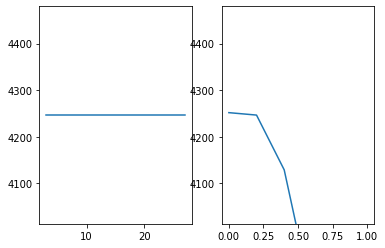

In [5]:
iter_nums = list(range(3, 30, 3))
dampings = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

plt.subplots(1, 2)

plt.subplot(1, 2, 1)
energies = []
for iter_num in iter_nums:
    energies.append(E(labels=naive_mean_field(*args, max_iter=iter_num, damping=0.2)))
plt.plot(iter_nums, energies, label=f'iters')
b, t = plt.ylim()

plt.subplot(1, 2, 2)
energies = []
for damping in dampings:
    energies.append(E(labels=naive_mean_field(*args, max_iter=10, damping=damping)))
plt.plot(dampings, energies, label=f'damping')
plt.ylim((b, t))

In [8]:
%timeit naive_mean_field(*args, max_iter=5)
%timeit loopy_belief_propagation(*args, max_iter=5)

13 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
94.4 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Benchmark on Potts Model

- LBP is much more stable than MF.
- MF can get similar results to LBP.

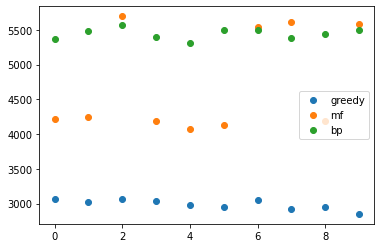

In [6]:
size = 40
n_states = 20

expids = list(range(10))
record = []
for expid in expids:
    with local_seed(expid):
        x = torch.normal(mean=0.0, std=1.0, size=[size, size, n_states])
        binary_edges = torch.tensor(make_grid_edges(x))
        binary_potentials = torch.normal(mean=0.0, std=1.0, size=[binary_edges.shape[0], n_states, n_states])
        unary_potentials = x.reshape(-1, n_states)
        args = (unary_potentials, binary_potentials, binary_edges)
        E = partial(compute_energy, *args)

        greedy = E(labels=torch.argmax(unary_potentials, axis=1))
        mf = E(labels=naive_mean_field(*args, max_iter=20, damping=0.2, track_best=False))
        bp = E(labels=loopy_belief_propagation(*args, max_iter=20, track_best=False))

        record.append([greedy, mf, bp])

plt.scatter(expids, torch.tensor(record)[:, 0], label='greedy')
plt.scatter(expids, torch.tensor(record)[:, 1], label='mf')
plt.scatter(expids, torch.tensor(record)[:, 2], label='bp')
plt.legend()

## Benchmark on Chain-Like CRF

Chain-Like CRF means: `A-B-C-D-E`, while some skip-binaries in a fixed window exist (`A-C`, `B-D`, `C-E`).

- LBP is always more stable than MF.
- The less factors, the better LBP.

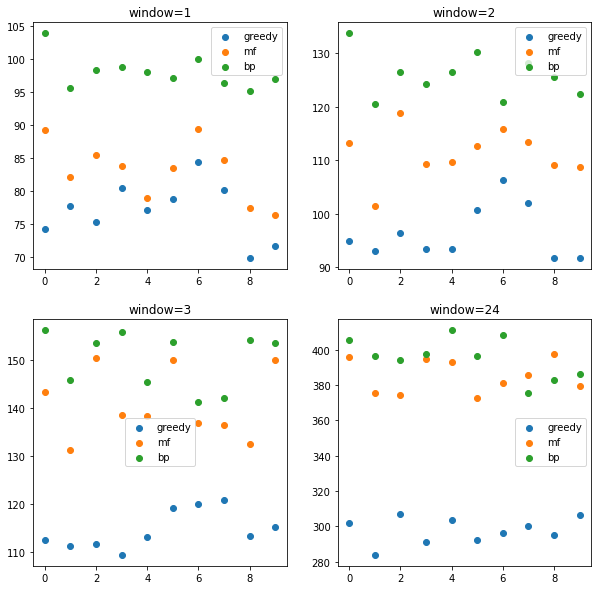

In [7]:
size = 25
n_states = 32

plt.subplots(2, 2, figsize=(10, 10))

for wid, window in enumerate([1, 2, 3, size-1]):
    plt.subplot(2, 2, wid + 1)
    expids = list(range(10))
    record = []

    for expid in expids:
        with local_seed(expid):            
            unary_potentials = torch.abs(torch.normal(mean=0.0, std=1.0, size=(size, n_states)))

            binary_edges = torch.tensor(generate_edges(size, window))
            binary_potentials = torch.abs(torch.normal(mean=0.0, std=1.0, size=(binary_edges.shape[0], n_states, n_states)))

            args = (unary_potentials, binary_potentials, binary_edges)
            E = partial(compute_energy, *args)

            greedy = E(labels=torch.argmax(unary_potentials, axis=1))
            mf = E(labels=naive_mean_field(*args, max_iter=20, damping=0.2, track_best=True))
            bp = E(labels=loopy_belief_propagation(*args, max_iter=20, track_best=True))
            # print(E(labels=inference_ad3(*args)))

            record.append([greedy, mf, bp])

    plt.scatter(expids, torch.tensor(record)[:, 0], label='greedy')
    plt.scatter(expids, torch.tensor(record)[:, 1], label='mf')
    plt.scatter(expids, torch.tensor(record)[:, 2], label='bp')
    plt.legend()
    plt.title(f"window={window}")